In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

from src.model import *


import io
import json
from os import path
import glob

In [2]:
obj_dims = (648, 486)

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
model_description = 'model-15.3'

In [5]:
np.random.seed(0)

In [6]:
# Dataset path
record_dir = path.join('..', 'data', model_description)
train_dataset_files = glob.glob(path.join(record_dir, 'train', '*'))
val_dataset_files = glob.glob(path.join(record_dir, 'validation', '*'))


# Paths for saving/loading model weights, predictions
base_path = path.join('..', 'models', model_description)
model_weights_path = path.join(base_path, model_description)
image_path = path.join(base_path, 'prediction-images')

In [7]:
os.mkdir(base_path)
os.mkdir(image_path)

FileExistsError: [Errno 17] File exists: '../models/model-15.3'

In [8]:
TRAIN_LENGTH = len(train_dataset_files)
VAL_LENGTH = len(val_dataset_files)
input_shape = (None, 648, 486, 1)
# input_shape = (None, 648, 486, 24)

obj_dims = (648, 486)

In [9]:
photon_counts = tf.constant([100., 1000., 10000.])

# Dataset Creation

In [10]:
def _parse_function(example_proto):
    feature_description = {
        'plane': tf.io.FixedLenFeature(obj_dims, tf.float32),
#         'sim': tf.io.FixedLenFeature((24, 648, 486), tf.float32)
        'sim': tf.io.FixedLenFeature(obj_dims, tf.float32)
        
    }
    example = tf.io.parse_single_example(example_proto, feature_description)
    
    
    plane = example['plane']
#     plane = tf.cast(plane, tf.float16)
#     plane = plane[4:644, 3:483] # Crop to target image size
#     plane = plane[4:644, 19:467]
    plane_max = tf.reduce_max(plane)
    plane_min = tf.reduce_min(plane)
    plane = (plane - plane_min) / (plane_max - plane_min)  # Normalize values to [0, 1]
    plane = plane[220:428, 181:305]


#     sim = tf.transpose(example['sim'], [1, 2, 0])
    sim = example['sim']
#     sim = tf.cast(sim, tf.float16)
    sim_max = tf.reduce_max(sim)
    sim_min = tf.reduce_min(sim)
    sim = (sim - sim_min) / (sim_max - sim_min)  # Normalize values to [0, 1]
    
#     # Adding Poisson noise to simulated measurements
#     photon_idx = tf.random.uniform(shape=(), minval=0, maxval=3, dtype=tf.int32)
#     photon_count = tf.gather(photon_counts, photon_idx)
#     sim = tf.squeeze(tf.random.poisson([1], sim * photon_count)) / photon_count
    
#     # Renormalize values to [0, 1]
#     sim_max = tf.reduce_max(sim)
#     sim_min = tf.reduce_min(sim)
#     sim = (sim - sim_min) / (sim_max - sim_min)
    
#     # Adding Gaussian noise to simulated measurements
#     a = tf.random.uniform((), 0.0063, 0.0063*4)
#     b = tf.random.uniform((), 0.06, 0.1)
#     noise = tf.random.normal(sim.shape, mean=b, stddev=a)
#     sim = sim + noise

#     # Renormalize values to [0, 1]
#     sim_max = tf.reduce_max(sim)
#     sim_min = tf.reduce_min(sim)
#     sim = (sim - sim_min) / (sim_max - sim_min)
    
    # Expand to channel dimension
    sim = sim[..., tf.newaxis]

    
    return sim, plane

def create_dataset(filenames, batch_size):
    """
    Takes in string array of filenames for TFRecord files containing samples.
    Returns: TFRecordDataset with given batch size
    """
    filenames = tf.random.shuffle(filenames)
    raw_dataset = tf.data.TFRecordDataset(filenames)
    
    dataset = raw_dataset.map(_parse_function)
    dataset = dataset.shuffle(256)
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    
    return dataset

In [11]:
BATCH_SIZE = 8
STEPS_PER_EPOCH = int(np.ceil(TRAIN_LENGTH / BATCH_SIZE))
VAL_STEPS = int(np.ceil(VAL_LENGTH / BATCH_SIZE))

train_dataset = create_dataset(train_dataset_files, BATCH_SIZE)
val_dataset = create_dataset(val_dataset_files, BATCH_SIZE)

# Logging

In [12]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def scaled_mse_loss(y_actual,y_pred):
    loss = K.square((y_actual-y_pred))
    loss = K.sum(loss)
    return loss

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def scaled_mse_loss(y_actual,y_pred):
    loss = K.square((y_actual-y_pred))
#     loss = K.sqrt(loss)
    loss = K.sum(loss)
    return loss

def plot_image_tensorboard(epoch, logs):
    # Create a plot to visualize image reconstruction progress
    
    # Call the model to get prediction
    pred = model.predict(val_sample[0][0][np.newaxis])

    # Create a mpl figure
    figure = plt.figure(figsize=(10,10))

    # Plot the prediction
    plt.subplot(1, 2, 1)
    plt.title("prediction")
    plt.imshow(pred[0].astype(np.float32))
    # Plot groundtruth
    plt.subplot(1, 2, 2)
    plt.title("ground truth")
    plt.imshow(val_sample[1][0].numpy().astype(np.float32))
    plot_image = plot_to_image(figure)
    with file_writer.as_default():
        tf.summary.image("Prediction vs Ground Truth", plot_image, step=epoch)

import datetime
log_dir=os.path.join('logs', model_description + '-fit') + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=1000000)
file_writer = tf.summary.create_file_writer(log_dir)

plot_image_tensorboard_cb = keras.callbacks.LambdaCallback(on_epoch_end=plot_image_tensorboard)

# Save model after epochs
checkpoint_cb = ModelCheckpoint(model_weights_path + '.e{epoch:03d}', monitor='val_loss', verbose=0, 
                             save_best_only=False, save_weights_only=True, mode='auto', 
                                save_freq=10*STEPS_PER_EPOCH)
checkpoint_best_cb = ModelCheckpoint(model_weights_path + '.best', monitor='val_loss', verbose=0,
                                    save_best_only=True, save_weights_only=True, mode='auto')

# Training

In [13]:
def SSIMLoss(y_true, y_pred):
    y_true = y_true[..., np.newaxis]
    y_pred = y_pred[..., np.newaxis]
    
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [14]:
comps_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/comps.npy'
weights_path = '/home/rshuai/research/u-net-reconstruction/data/PSFs/processed/rank24_z0_ds2_normalized/weights.npy'

# Load in comps and weights
h = np.load(comps_path)
weights = np.load(weights_path)

psf = tf.squeeze(tf.math.reduce_sum(h*weights, axis=0))
psf = psf / tf.math.reduce_max(psf)
# K = 2000 #this variable can be learned, it has be greater than zero though
K = 1

In [15]:
# # UNet for components
# K = 1

# comps = np.squeeze(h, axis=1).transpose(1, 2, 0)
# assert comps.shape == (648, 486, 24)

# model = UNet_2d_wiener_components(comps, K)

In [16]:
# model = UNet_2d()
model = UNet_2d_wiener(psf, K)
# model = UNet_2d_wiener()

initial_learning_rate = 1e-4
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
#                                                             decay_steps=STEPS_PER_EPOCH*40,
#                                                             decay_rate=0.5,
#                                                             staircase=False)

adam = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(optimizer=adam, loss=SSIMLoss, metrics=SSIMLoss)
# model.compile(optimizer=adam, loss=tf.keras.losses.MeanAbsoluteError(), metrics=[tf.keras.losses.MeanAbsoluteError()])
model.build(input_shape)
model.summary()

Model: "u_net_2d_wiener"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
wiener_deconvolution_one_ste multiple                  314929    
_________________________________________________________________
stack_encoder (StackEncoder) multiple                  5592      
_________________________________________________________________
stack_encoder_1 (StackEncode multiple                  51200     
_________________________________________________________________
stack_encoder_2 (StackEncode multiple                  222208    
_________________________________________________________________
stack_encoder_3 (StackEncode multiple                  886784    
_________________________________________________________________
stack_encoder_4 (StackEncode multiple                  3543040   
_________________________________________________________________
stack_encoder_5 (StackEncode multiple              

In [17]:
EPOCHS = 450

In [18]:
val_sample = next(iter(val_dataset)) # Used for logging and plotting.

In [19]:
model.fit(train_dataset, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, 
          callbacks=[plot_image_tensorboard_cb, tensorboard_callback, checkpoint_cb, checkpoint_best_cb], 
          validation_data=val_dataset, validation_steps=VAL_STEPS)

model.save_weights(model_weights_path, save_format='tf')

Epoch 1/450
625/625 [==============================] - 327s 523ms/step - loss: 0.4629 - SSIMLoss: 0.4629 - val_loss: 0.5806 - val_SSIMLoss: 0.5806
Epoch 2/450
625/625 [==============================] - 299s 478ms/step - loss: 0.2898 - SSIMLoss: 0.2898 - val_loss: 0.2677 - val_SSIMLoss: 0.2677
Epoch 3/450
625/625 [==============================] - 300s 481ms/step - loss: 0.2656 - SSIMLoss: 0.2656 - val_loss: 0.2617 - val_SSIMLoss: 0.2617
Epoch 4/450
625/625 [==============================] - 302s 483ms/step - loss: 0.2522 - SSIMLoss: 0.2522 - val_loss: 0.2515 - val_SSIMLoss: 0.2515
Epoch 5/450
625/625 [==============================] - 300s 479ms/step - loss: 0.2399 - SSIMLoss: 0.2399 - val_loss: 0.2562 - val_SSIMLoss: 0.2562
Epoch 6/450
625/625 [==============================] - 302s 484ms/step - loss: 0.2343 - SSIMLoss: 0.2343 - val_loss: 0.2352 - val_SSIMLoss: 0.2352
Epoch 7/450
625/625 [==============================] - 301s 482ms/step - loss: 0.2304 - SSIMLoss: 0.2304 - val_loss: 0

KeyboardInterrupt: 

# Prediction Visualization, Timing Tests

In [20]:
NUM_DISPLAY = 15

In [21]:
# model = UNet_2d()
model = UNet_2d_wiener(np.zeros_like(psf), K)

epoch = 'best'
model.load_weights(model_weights_path + '.{}'.format(epoch))

In [22]:
import time

In [23]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [26]:
# preds = np.zeros((NUM_DISPLAY, 640, 448))
# ground_truths = np.zeros((NUM_DISPLAY, 640, 448))
preds = np.zeros((NUM_DISPLAY, 208, 124))
ground_truths = np.zeros((NUM_DISPLAY, 208, 124))
sims = np.zeros((NUM_DISPLAY, 648, 486))


### Train

In [27]:
t0 = time.perf_counter()
i = 0
for sim, plane in train_dataset.unbatch():
    preds[i] = model.predict(sim[np.newaxis])
    ground_truths[i] = plane
    sims[i] = np.squeeze(sim)
    i += 1
    if i == NUM_DISPLAY:
        break
        
# assert(i == VAL_LENGTH)

t1 = time.perf_counter()

print('Prediction time per sample:', (t1 - t0) / NUM_DISPLAY, 's')

Prediction time per sample: 0.055530744263281424 s


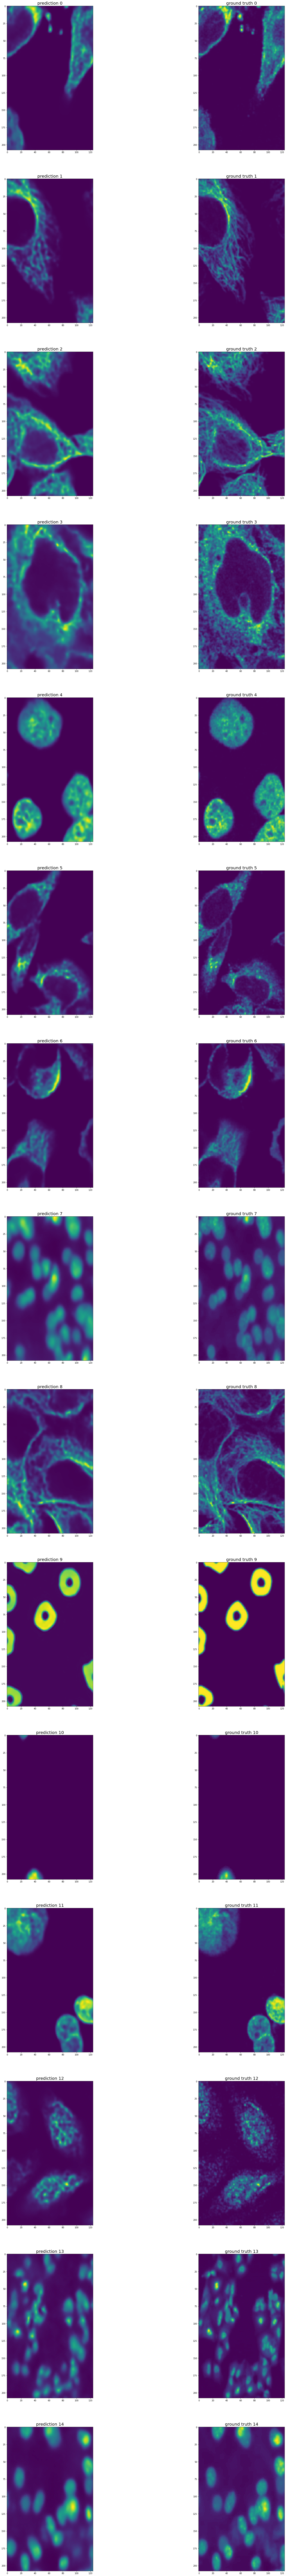

In [28]:
fig=plt.figure(figsize=(30, 15 * NUM_DISPLAY))
rows, columns = NUM_DISPLAY, 2
for i in range(NUM_DISPLAY):
    # Plot prediction
    s = fig.add_subplot(rows, columns, columns*i+1)
    s.set_title("prediction {0}".format(i), size=20)
    plt.imshow(preds[i])
    
    # Plot ground truth
    s = fig.add_subplot(rows, columns, columns*i+2)
    s.set_title("ground truth {0}".format(i), size=20)
    plt.imshow(ground_truths[i])
    
plt.savefig(path.join(image_path, 'train_{}.pdf'.format(epoch)))

### Validation

In [29]:
t0 = time.perf_counter()
i = 0
for sim, plane in val_dataset.unbatch():
    preds[i] = model.predict(sim[np.newaxis])
    ground_truths[i] = plane
    sims[i] = np.squeeze(sim)
    i += 1
    if i == NUM_DISPLAY:
        break
        
# assert(i == VAL_LENGTH)

t1 = time.perf_counter()

print('Prediction time per sample:', (t1 - t0) / NUM_DISPLAY, 's')

Prediction time per sample: 0.05564079779821138 s


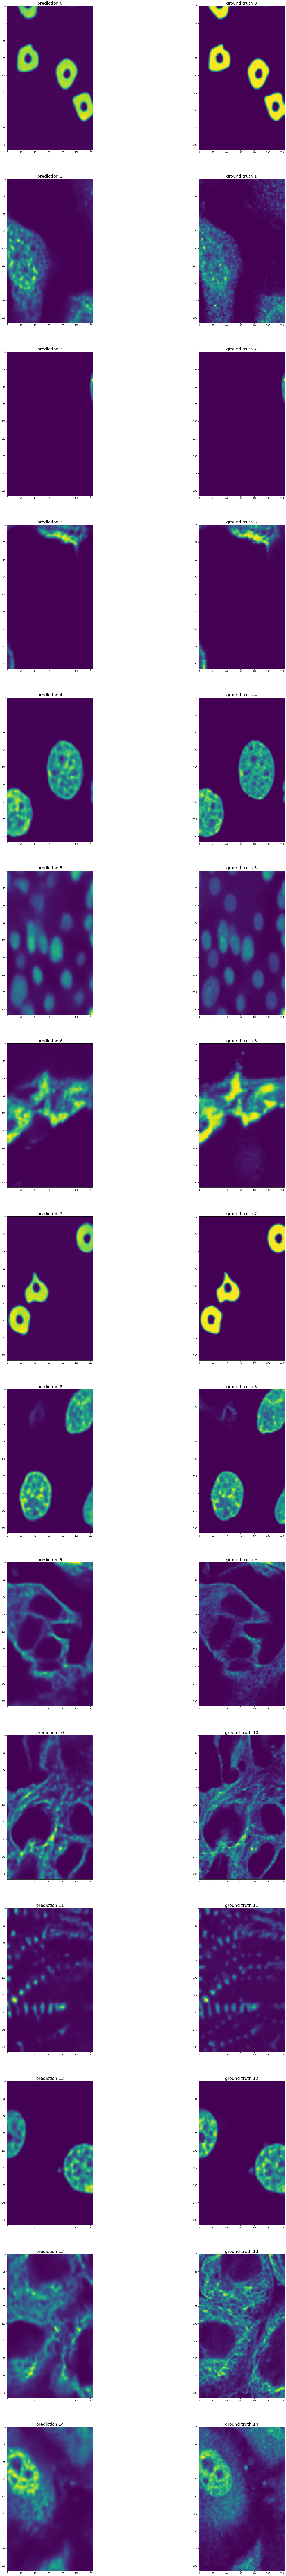

In [30]:
fig=plt.figure(figsize=(30, 15 * NUM_DISPLAY))
rows, columns = NUM_DISPLAY, 2
for i in range(NUM_DISPLAY):
    # Plot prediction
    s = fig.add_subplot(rows, columns, columns*i+1)
    s.set_title("prediction {0}".format(i), size=20)
    plt.imshow(preds[i])
    
    # Plot ground truth
    s = fig.add_subplot(rows, columns, columns*i+2)
    s.set_title("ground truth {0}".format(i), size=20)
    plt.imshow(ground_truths[i])
    
plt.savefig(path.join(image_path, 'validation_{}.pdf'.format(epoch)))

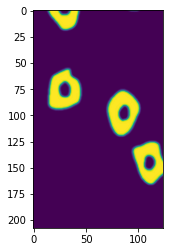

In [31]:
plt.imshow(ground_truths[0])